<a href="https://colab.research.google.com/github/gyaneshhere/LLM-Security-and-Observability/blob/main/LangFuse/Develop/Tracing/cookbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install langfuse
%pip install langchain langgraph langchain_openai langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.2/145.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.9/433.9 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6

In [3]:
from google.colab import userdata


In [7]:
import os

# get keys for your project from https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = userdata.get('LANGFUSE_PUBLIC_KEY')
os.environ["LANGFUSE_SECRET_KEY"] = userdata.get('LANGFUSE_SECRET_KEY')
#os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com" # for EU data region
os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com" # for US data region

# your openai key
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [8]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list". The `add_messages` function in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

llm = ChatOpenAI(model = "gpt-4o", temperature = 0.2)

# The chatbot node function takes the current State as input and returns an updated messages list. This is the basic pattern for all LangGraph node functions.
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# Add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.
graph_builder.add_node("chatbot", chatbot)

# Add an entry point. This tells our graph where to start its work each time we run it.
graph_builder.set_entry_point("chatbot")

# Set a finish point. This instructs the graph "any time this node is run, you can exit."
graph_builder.set_finish_point("chatbot")

# To be able to run our graph, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.
graph = graph_builder.compile()

In [9]:
from langfuse.callback import CallbackHandler

# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()

for s in graph.stream({"messages": [HumanMessage(content = "What is Langfuse?")]},
                      config={"callbacks": [langfuse_handler]}):
    print(s)

{'chatbot': {'messages': [AIMessage(content='Langfuse is a platform designed to help developers and companies monitor, debug, and improve their AI applications, particularly those involving natural language processing (NLP) and large language models (LLMs). It provides tools for tracking the performance of AI models, analyzing their outputs, and gaining insights into how they can be optimized for better results. Langfuse aims to streamline the process of managing AI applications by offering features like logging, analytics, and error tracking, which can be crucial for maintaining and enhancing the quality of AI-driven products.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 108, 'prompt_tokens': 13, 'total_tokens': 121, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'g

**Example Trace in Langgraph**

https://us.cloud.langfuse.com/project/cm6lmc14y022zvate2r5eb0xy/traces/c7b0cbbb-5de1-4050-8753-26d16454a898?timestamp=2025-04-19T03:02:45.809Z&display=details

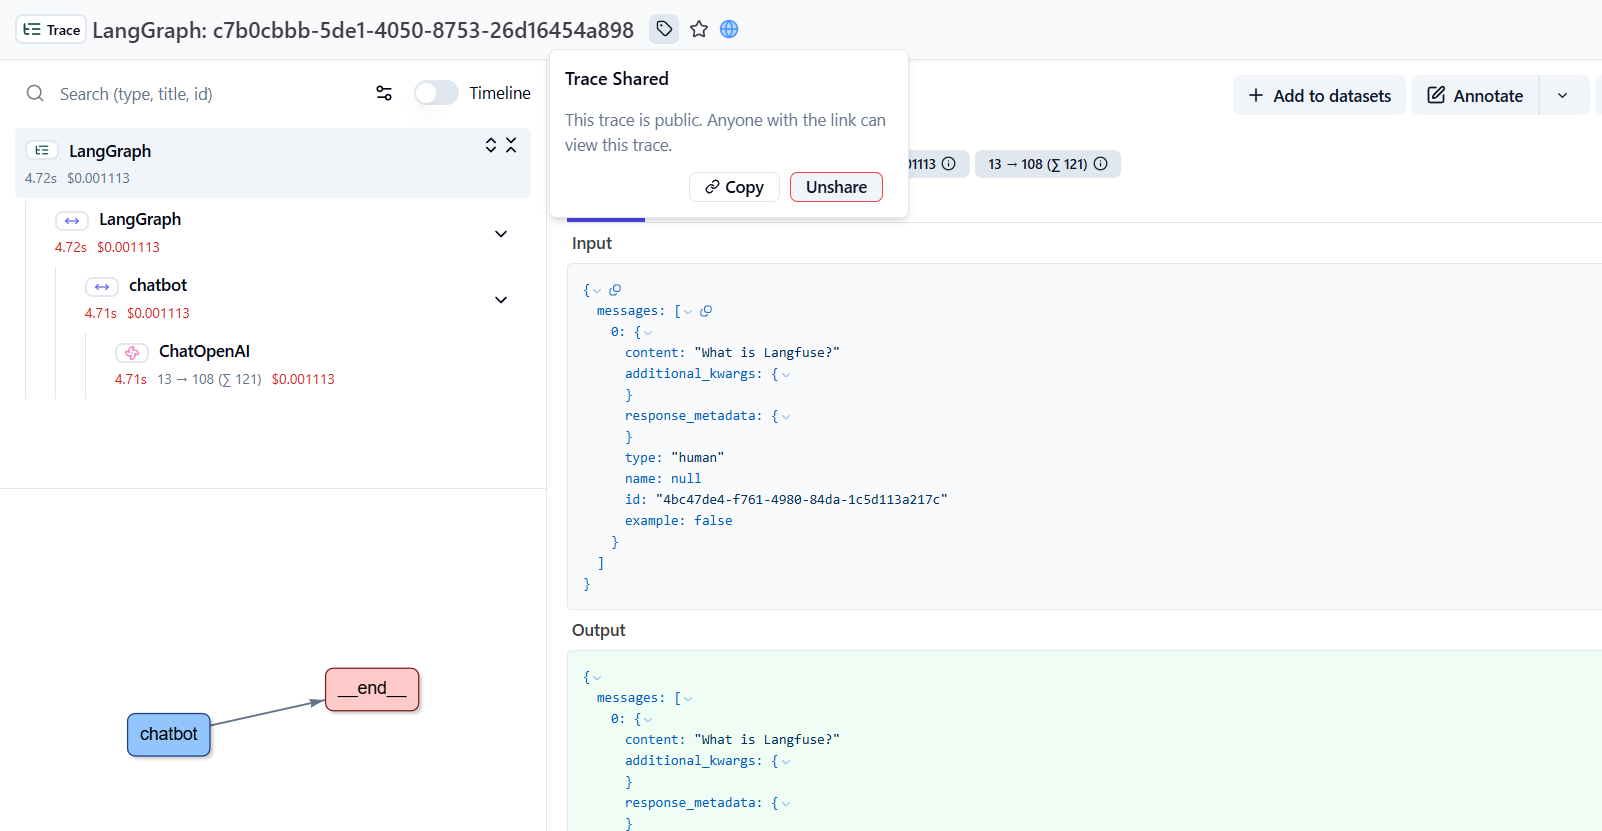
